## Introduction

This is the assignment 1 submission of Team Beta. Members are Naina Bhalla, Arnab Datta, Shikhar Gupta.

## Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
import pickle
from sklearn.preprocessing import MinMaxScaler

## Defining a class for loading the dataset

In [2]:
class DataLoader:
    def __init__(self , path="/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv"):
        df=pd.read_csv(path)
        self.y=df["Chance of Admit "]
        self.X=df.drop(columns=["Serial No.","Chance of Admit "])
    def datascaler(self):  
        columns = ["GRE Score", "TOEFL Score", "CGPA"]
        scaler = MinMaxScaler()  # to scale the necessary columns
        self.X[columns] = scaler.fit_transform(self.X[columns])

**Implementing the class DataLoader on the given dataset**

In [3]:
train=DataLoader("/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv")
test=DataLoader("/kaggle/input/graduate-admissions/Admission_Predict.csv")
train.datascaler()
train.X.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,0.94,0.928571,4,4.5,4.5,0.913462,1
1,0.68,0.535714,4,4.0,4.5,0.663462,1
2,0.52,0.428571,3,3.0,3.5,0.384615,1
3,0.64,0.642857,3,3.5,2.5,0.599359,1
4,0.48,0.392857,2,2.0,3.0,0.451923,0


**Correlation matrix of the training dataset**

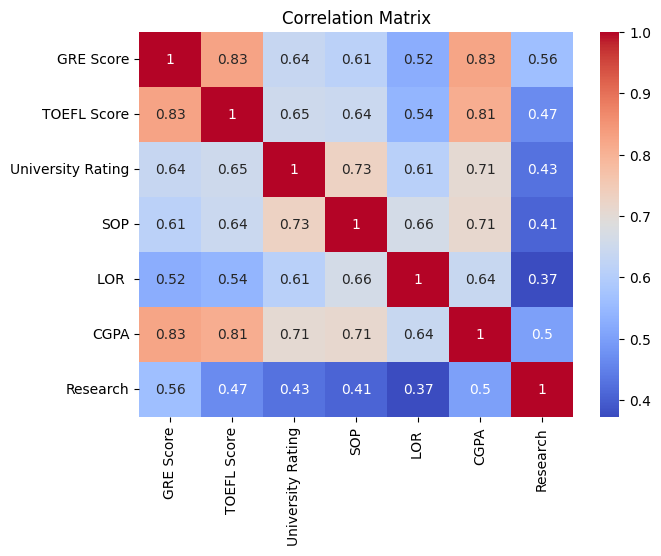

In [4]:
correlation_matrix = train.X.corr()
plt.figure(figsize=(7,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## Defining class LinearReg for the Linear Regression

In [5]:
class LinearReg:
    
    def __init__(self, epochs =10, lr=0.01, reg_hp=0.0001,reg_type=None,gd_type="vanilla", verbose=True, batch_size=None):
        self.epochs=epochs
        self.lr=lr
        self.reg_hp=reg_hp
        self.reg_type=reg_type
        self.gd_type=gd_type
        self.verbose=verbose
        self.batch_size = batch_size 
    
    def cost(self,X,y): #to calculate the cost as per the given regularization( l1 OR l2 OR mse(default) )
        y_pred = X.dot(self.w) + self.b
        mse = np.mean((y - y_pred)**2)
        
        if self.reg_type == 'l2':
            reg_cost = self.reg_hp * np.sum(self.w ** 2)
            total_cost = mse + reg_cost
            
        elif self.reg_type == 'l1':
            reg_cost = self.reg_hp * np.sum(np.abs(self.w))
            total_cost = mse + reg_cost
            
        else:
            total_cost = mse
        
        return total_cost

    def fit(self,X,y):
        #initializing the weights and biases
        self.m, self.n = X.shape 
        self.w=np.zeros(self.n)
        self.b=0
        self.X=X
        self.y=y
        self.loss= []  # to store the loss history  
        for i in range(self.epochs):
            self.update_weights()
            cost=self.cost(self.X,self.y)
            self.loss.append(cost)
            if self.verbose:  #if verbose==True then prints the verbose
                print(f"Epoch {i+1}  Loss:{cost:.4f}")
        return self
        
    def update_weights(self) :  #to update weights for each epoch
        if self.gd_type == "vanilla":
            y_pred = self.X.dot( self.w ) + self.b    
            dw = - ( 2 * ( self.X.T ).dot( self.y-y_pred ))/self.m 
            db = - 2 * np.sum( self.y - y_pred ) / self.m
            self.w = self.w - self.lr * dw
            self.b = self.b - self.lr * db

        elif self.gd_type == "sgd":
            for i in range (self.m):
                xi = self.X[i].reshape(1,-1)
                yi = self.y[i].reshape(1,-1)
                y_pred = xi.dot(self.w) +self.b
                dw = -2 * (xi.T).dot(yi - y_pred)
                db = -2 * (yi - y_pred)
                self.w -= self.lr * dw
                self.b -= self.lr * db
            return

        elif self.gd_type == "mini-batch":
            for start in range(0, self.m, self.batch_size):
                last = start + self.batch_size
                X_batch = self.X[start:last]
                y_batch = self.y[start:last]
                y_pred = X_batch.dot(self.w) + self.b    
                dw = - (2 * (X_batch.T).dot(y_batch - y_pred)) / len(y_batch)
                db = - 2 * np.sum(y_batch - y_pred) / len(y_batch)
                self.w = self.w - self.lr * dw
                self.b = self.b - self.lr * db 

        if self.reg_type == "ridge":
            dw += (self.reg_hp / self.m) * self.w
        elif self.reg_type == "lasso":
            dw += (self.reg_hp / self.m) * np.sign(self.w)

        self.w -= self.lr * dw
        self.b -= self.lr * db 
        return self
    
    def plot_loss(self):
        # to plot the loss vs the epochs
        plt.figure(figsize=(5,5))
        plt.plot(range(len(self.loss)), self.loss, label="Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Cost")
        plt.title("Loss vs Epochs")
        plt.legend()
        plt.show()


    def predict(self,X):  
        pred=(self.X.dot(self.w) + self.b)
        return pred
    
    
    def save(self, filename="model.pkl"):
        with open(filename, 'wb') as file:
            model_params = {
                'weights': self.w,
                'bias': self.b,
                'epochs': self.epochs,
                'learning_rate': self.lr,
                'regularization_hp': self.reg_hp,
                'regularization_type': self.reg_type,
                'gd_type': self.gd_type,
                'batch_size' : self.batch_size
            }
            pickle.dump(model_params, file)

    def load(self, filename):
        with open(filename, 'rb') as file:
            model_params = pickle.load(file)
            self.w = model_params['weights']
            self.b = model_params['bias']
            self.epochs = model_params['epochs']
            self.lr = model_params['learning_rate']
            self.reg_hp = model_params['regularization_hp']
            self.reg_type = model_params['regularization_type']
            self.gd_type = model_params['gd_type']
            self.batch_size = model_params['batch_size']    
        

**Function to evaluate the final model**

In [6]:
def evaluate(y_test,y_pred):
    mse=mean_squared_error(y_test,y_pred)
    mae=mean_absolute_error(y_test,y_pred)
    r2=r2_score(y_test,y_pred)
    print(f"Mean Squared Error: {mse:.3f}")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"R^2 Score: {r2:.3f}")

    #Scatter plot for actual vs predicted values
    plt.figure(figsize=(5,5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    sns.regplot(x=y_test, y=y_pred, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted")
    plt.show()

    

## Predictions

**Using Vanilla Gradient Descent and L1 regularisation**

Epoch 1  Loss:0.1538
Epoch 2  Loss:0.0509
Epoch 3  Loss:0.0235
Epoch 4  Loss:0.0162
Epoch 5  Loss:0.0142
Epoch 6  Loss:0.0136
Epoch 7  Loss:0.0134
Epoch 8  Loss:0.0133
Epoch 9  Loss:0.0133
Epoch 10  Loss:0.0132
Epoch 11  Loss:0.0132
Epoch 12  Loss:0.0131
Epoch 13  Loss:0.0130
Epoch 14  Loss:0.0130
Epoch 15  Loss:0.0129
Epoch 16  Loss:0.0129
Epoch 17  Loss:0.0128
Epoch 18  Loss:0.0128
Epoch 19  Loss:0.0127
Epoch 20  Loss:0.0127
Epoch 21  Loss:0.0126
Epoch 22  Loss:0.0126
Epoch 23  Loss:0.0125
Epoch 24  Loss:0.0125
Epoch 25  Loss:0.0124
Epoch 26  Loss:0.0124
Epoch 27  Loss:0.0123
Epoch 28  Loss:0.0123
Epoch 29  Loss:0.0122
Epoch 30  Loss:0.0122
Epoch 31  Loss:0.0121
Epoch 32  Loss:0.0121
Epoch 33  Loss:0.0120
Epoch 34  Loss:0.0120
Epoch 35  Loss:0.0120
Epoch 36  Loss:0.0119
Epoch 37  Loss:0.0119
Epoch 38  Loss:0.0118
Epoch 39  Loss:0.0118
Epoch 40  Loss:0.0117
Epoch 41  Loss:0.0117
Epoch 42  Loss:0.0117
Epoch 43  Loss:0.0116
Epoch 44  Loss:0.0116
Epoch 45  Loss:0.0115
Epoch 46  Loss:0.01

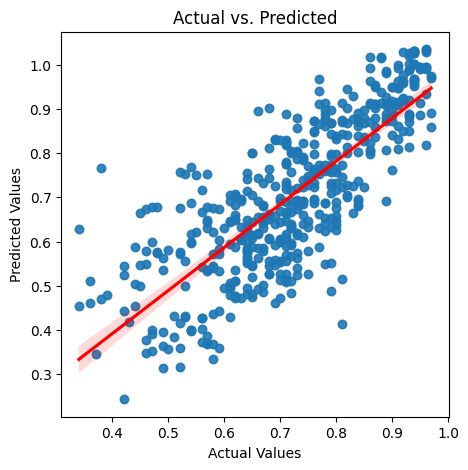

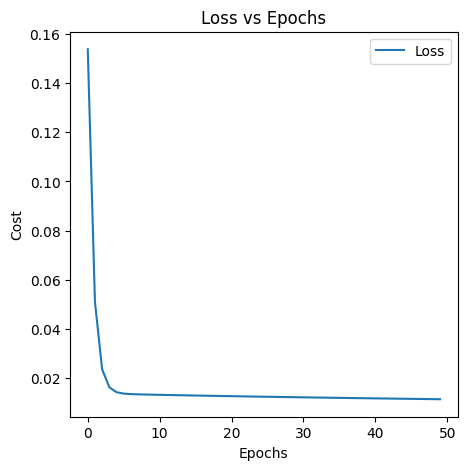

In [7]:
model_vanilla = LinearReg(epochs=50, gd_type="vanilla",reg_type="l1", verbose=True)
model_vanilla.fit(train.X, train.y)
vanilla_pred = model_vanilla.predict(train.X)
evaluate(train.y,vanilla_pred)
model_vanilla.plot_loss()
model_vanilla.save("Vanilla_Model.pkl")